## 1. 필요한 패키지 불러오기

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import defaultdict

import re
import gensim
from konlpy.tag import Mecab

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.initializers import Constant

mecab이 사용되지 않은 오류가 발생하면 다시 설치해주어야 합니다.  
!bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)

word2vec gensim을 사용하기 위해서 버전 다운그레이드가 필요햡니다.  
!pip install --upgrade gensim==3.8.3

## 2. 데이터 불러오기

In [2]:
data = pd.read_csv("./data/ChatbotData.csv")
print(f"데이터 개수 : {data.shape[0]}")
data.head()

데이터 개수 : 11823


,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


## 3. 데이터 전처리 및 시각화

#### 결측치 확인

In [3]:
data.isna().sum()

Q        0
A        0
label    0
dtype: int64

결측값은 존재하지 않는 것으로 보입니다.

#### 형태소 분석기 Mecab으로 토큰화하는 경우

In [4]:
def mecab_tokenization(corpus, tokenizer):
    # https://pypi.org/project/python-mecab-ko/
    
    # 특수문자 제거
    corpus = re.sub("[^ㄱ-ㅎ가-힣0-9A-Za-z?!.,]", " ", corpus)
    corpus = re.sub("[ ]+", " ", corpus)
    corpus = corpus.strip()
    
    # 토큰화
    corpus = mecab.morphs(corpus)

    # 불용어 제거
    stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']
    corpus = [word for word in corpus if word not in stopwords]    
    
    return corpus

In [5]:
mecab = Mecab()

tqdm.pandas()
data["pre_Q"] = data["Q"].progress_apply(lambda x : mecab_tokenization(x, mecab))
data["pre_A"] = data["A"].progress_apply(lambda x : mecab_tokenization(x, mecab))

100%|██████████| 11823/11823 [00:00<00:00, 16385.02it/s]


#### 문장별 단어의 개수 히스토그램

In [6]:
data["len_Q"] = data["pre_Q"].apply(lambda x: len(x))
data["len_A"] = data["pre_A"].apply(lambda x: len(x))

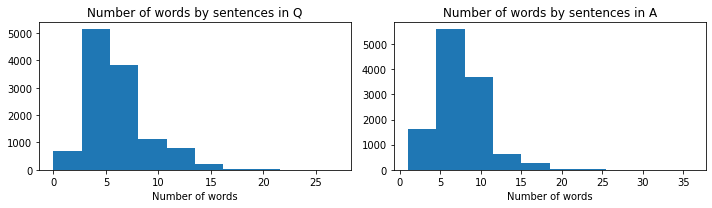

In [7]:
plt.figure(figsize = (10, 3))
plt.subplot(1,2,1)
plt.hist(data["len_Q"])
plt.title("Number of words by sentences in Q")
plt.xlabel("Number of words")

plt.subplot(1,2,2)
plt.hist(data["len_A"])
plt.title("Number of words by sentences in A")
plt.xlabel("Number of words")

plt.tight_layout()
plt.show()

#### subword로 토큰화 하는 경우

#### 텍스트 전처리

In [8]:
def encoder_preprocessing(corpus):
    # https://pypi.org/project/python-mecab-ko/
    
    # 특수문자 제거
    corpus = re.sub("[^ㄱ-ㅎ가-힣0-9]", " ", corpus)
    corpus = re.sub(" [.]|[.] | [.] ", ".", corpus)
    corpus = re.sub(" [,]|[,] | [,] ", ",", corpus)
    corpus = re.sub(" [?]|[?] | [?] ", "?", corpus)
    corpus = re.sub(" [!]|[!] | [!] ", "!", corpus)
    # 형태소 분석
    split_corpus = mecab.morphs(corpus)
    
    # 불용어 제거
    stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']
    corpus = [word for word in split_corpus if word not in stopwords]    
    corpus = " ".join(corpus)
    corpus = re.sub("[ ]+", " ", corpus)
    corpus = corpus.strip()
    
    return corpus


def decoder_preprocessing(corpus):
    # https://pypi.org/project/python-mecab-ko/
    
    # 특수문자 제거
    corpus = re.sub("[^ㄱ-ㅎ가-힣0-9A-Za-z?!.,]", " ", corpus)
    corpus = re.sub(" [.]|[.] | [.] ", ".", corpus)
    corpus = re.sub(" [,]|[,] | [,] ", ",", corpus)
    corpus = re.sub(" [?]|[?] | [?] ", "?", corpus)
    corpus = re.sub(" [!]|[!] | [!] ", "!", corpus)
    
    corpus = re.sub("[ ]+", " ", corpus)
    corpus = corpus.strip()
    return corpus

In [9]:
mecab = Mecab()

# encoder 문자 전처리
Q = data["Q"].apply(lambda x: encoder_preprocessing(x))
# 전처리 후 길이가 0인 데이터 제거
remove_index_Q = [ind for ind, q in enumerate(Q) if len(q) == 0]


# decoder 문자 전처리
A = data["A"].apply(lambda x: decoder_preprocessing(x))
# 전처리 후 길이가 0인 데이터 제거
remove_index_A = [ind for ind, a in enumerate(A) if len(a) == 0]

remove_index = remove_index_Q + remove_index_A

Q, A = np.array(Q), np.array(A)
Q = np.delete(Q, remove_index)
A = np.delete(A, remove_index)


q_and_a = np.concatenate([Q, A])
q_and_a.shape

(23640,)

TensorFlow Datasets SubwordTextEncoder를 토크나이저로 사용한다.  단어보다 더 작은 단위인 Subword를 기준으로 토크나이징하고,  각 토큰을 고유한 정수로 인코딩한다.


In [213]:
# 질문과 답변 데이터셋에 대해서 Vocabulary 생성. (Tensorflow 2.3.0 이상) (클라우드는 2.4 입니다)
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(q_and_a, target_vocab_size=2**13)

# 시작 토큰과 종료 토큰에 고유한 정수를 부여합니다.
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]
print(START_TOKEN, END_TOKEN)
# 시작 토큰과 종료 토큰을 고려하여 +2를 하여 단어장의 크기를 산정합니다.
VOCAB_SIZE = tokenizer.vocab_size + 2
print(VOCAB_SIZE)

# 임의의 22번째 샘플에 대해서 정수 인코딩 작업을 수행.
# 각 토큰을 고유한 정수로 변환
print('정수 인코딩 후의 21번째 질문 샘플: {}'.format(tokenizer.encode(data["Q"][21])))
print('정수 인코딩 후의 21번째 답변 샘플: {}'.format(tokenizer.encode(data["A"][21])))

[8118] [8119]
8120
정수 인코딩 후의 21번째 질문 샘플: [223, 728, 241, 1052, 3114]
정수 인코딩 후의 21번째 답변 샘플: [1028, 5471, 22, 3003, 499, 7908]


In [215]:
# 0 ~ 8117 = 8118개
for i in range(tokenizer.vocab_size)[:10]:
    print(tokenizer.decode([i]))


하 
어
고 
좋 
거예요
게 
을 
나 
아 


In [216]:
# 최대 문장에 들어가는 단어의 개수
MAX_LENGTH = 35

# 정수 인코딩, 최대 길이를 초과하는 샘플 제거, 패딩
def tokenize_and_filter(inputs, outputs):
    tokenized_inputs, tokenized_outputs = [], []
    
    for (sentence1, sentence2) in zip(inputs, outputs):
        # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
        sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
        sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

        # 최대 길이 40 이하인 경우에만 데이터셋으로 허용
        if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
            tokenized_inputs.append(sentence1)
            tokenized_outputs.append(sentence2)
  
  # 최대 길이 40으로 모든 데이터셋을 패딩
    tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(tokenized_inputs, 
                                                                     maxlen=MAX_LENGTH, 
                                                                     padding='pre')
    tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(tokenized_outputs, 
                                                                      maxlen=MAX_LENGTH, 
                                                                      padding='pre')
  
    return tokenized_inputs, tokenized_outputs

In [217]:
questions, answers = tokenize_and_filter(Q, A)
print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 질문 샘플 개수: {}'.format(len(questions)))
print('필터링 후의 답변 샘플 개수: {}'.format(len(answers)))

단어장의 크기 : 8120
필터링 후의 질문 샘플 개수: 11820
필터링 후의 답변 샘플 개수: 11820


In [16]:
BATCH_SIZE = 128
BUFFER_SIZE = len(questions)

# 디코더는 이전의 target을 다음의 input으로 사용합니다.
# 이에 따라 outputs에서는 START_TOKEN을 제거하겠습니다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1]
    },
    {
        'outputs': answers[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

#### 임베딩 벡터 전이학습 적용

In [17]:
word2vec_path = './ko.bin'
word2vec = gensim.models.Word2Vec.load(word2vec_path)
word_vector_dim = 200  # 워드 벡터의 차원수
embedding_matrix = np.random.rand(VOCAB_SIZE, word_vector_dim)

tmp = []
# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(tokenizer.vocab_size):
    if tokenizer.decode([i]) in word2vec:
        tmp += [tokenizer.decode([i])]
        embedding_matrix[i] = word2vec[tokenizer.decode([i])]
embedding_matrix.shape

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  This is separate from the ipykernel package so we can avoid doing imports until


(200,)

In [19]:
print(f"임베딩 벡터를 사용하는 단어의 개수 : {len(tmp)}")

임베딩 벡터를 사용하는 단어의 개수 : 1629


## 4. Transformer 구조 구현하기

### 4.1 Postional encoding layer

In [10]:
# 포지셔널 인코딩 레이어
class PositionalEncoding(tf.keras.layers.Layer):

    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)

    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return position * angles

    def positional_encoding(self, position, d_model):
        # 각도 배열 생성
        angle_rads = self.get_angles(
            position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
            d_model=d_model)

        # 배열의 짝수 인덱스에는 sin 함수 적용
        sines = tf.math.sin(angle_rads[:, 0::2])
        # 배열의 홀수 인덱스에는 cosine 함수 적용
        cosines = tf.math.cos(angle_rads[:, 1::2])

        # sin과 cosine이 교차되도록 재배열
        pos_encoding = tf.stack([sines, cosines], axis=0)
        pos_encoding = tf.transpose(pos_encoding,[1, 2, 0]) 
        pos_encoding = tf.reshape(pos_encoding, [position, d_model])

        pos_encoding = pos_encoding[tf.newaxis, ...]
        return tf.cast(pos_encoding, tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

### 4.2 Scaled dot product attention

In [11]:
# 스케일드 닷 프로덕트 어텐션 함수
def scaled_dot_product_attention(query, key, value, mask):
    # 어텐션 가중치는 Q와 K의 닷 프로덕트
    matmul_qk = tf.matmul(query, key, transpose_b=True)

    # 가중치를 정규화
    depth = tf.cast(tf.shape(key)[-1], tf.float32)
    logits = matmul_qk / tf.math.sqrt(depth)
    # 패딩에 마스크 추가
    if mask is not None:
        logits += (mask * -1e9)

    # softmax적용
    attention_weights = tf.nn.softmax(logits, axis=-1)

    # 최종 어텐션은 가중치와 V의 닷 프로덕트
    output = tf.matmul(attention_weights, value)
    return output

### 4.3 Multi-head attention layer

In [12]:
class MultiHeadAttention(tf.keras.layers.Layer):
    
    def __init__(self, d_model, num_heads, name="multi_head_attention"):
        super(MultiHeadAttention, self).__init__(name=name)
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.query_dense = tf.keras.layers.Dense(units=d_model)
        self.key_dense = tf.keras.layers.Dense(units=d_model)
        self.value_dense = tf.keras.layers.Dense(units=d_model)

        self.dense = tf.keras.layers.Dense(units=d_model)

        
    def split_heads(self, inputs, batch_size):
        inputs = tf.reshape(
            inputs, shape=(batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(inputs, perm=[0, 2, 1, 3])

    
    def call(self, inputs):
        query, key, value, mask = inputs['query'], inputs['key'], inputs[
            'value'], inputs['mask']
        batch_size = tf.shape(query)[0]

        # Q, K, V에 각각 Dense를 적용합니다
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)

        # 병렬 연산을 위한 머리를 여러 개 만듭니다
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        # 스케일드 닷 프로덕트 어텐션 함수
        scaled_attention = scaled_dot_product_attention(query, key, value, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

        # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다
        concat_attention = tf.reshape(scaled_attention,
                                      (batch_size, -1, self.d_model))

        # 최종 결과에도 Dense를 한 번 더 적용합니다
        outputs = self.dense(concat_attention)

        return outputs

### 4.4 Masking

#### 4.4.1 Padding masking

In [13]:
def create_padding_mask(x):
    mask = tf.cast(tf.math.equal(x, 0), tf.float32)
    # (batch_size, 1, 1, sequence length)
    return mask[:, tf.newaxis, tf.newaxis, :]

In [14]:
print(create_padding_mask(tf.constant([[1, 2, 0, 3, 0], [0, 0, 0, 4, 5]])))

tf.Tensor(
[[[[0. 0. 1. 0. 1.]]]


 [[[1. 1. 1. 0. 0.]]]], shape=(2, 1, 1, 5), dtype=float32)


#### 4.4.2 Look ahead masking

In [15]:
def create_look_ahead_mask(x):
    seq_len = tf.shape(x)[1]
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    padding_mask = create_padding_mask(x)
    return tf.maximum(look_ahead_mask, padding_mask)

In [16]:
print(create_look_ahead_mask(tf.constant([[1, 2, 3, 4, 5]])))

tf.Tensor(
[[[[0. 1. 1. 1. 1.]
   [0. 0. 1. 1. 1.]
   [0. 0. 0. 1. 1.]
   [0. 0. 0. 0. 1.]
   [0. 0. 0. 0. 0.]]]], shape=(1, 1, 5, 5), dtype=float32)


### 4.5 Encoder

In [17]:
# 인코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 두 개의 서브 레이어가 존재합니다.
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

    # 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
    attention = MultiHeadAttention(
        d_model, num_heads, name="attention")({
        'query': inputs,
        'key': inputs,
        'value': inputs,
        'mask': padding_mask
    })

    # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행
    attention = tf.keras.layers.Dropout(rate=dropout)(attention)
    attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

    # 두 번째 서브 레이어 : 2개의 완전연결층
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(attention + outputs)

    return tf.keras.Model(
        inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [37]:
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")

    # 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # 임베딩 레이어
    embeddings = tf.keras.layers.Embedding(
        vocab_size, 
        d_model,
        embeddings_initializer=Constant(embedding_matrix),
        trainable=True
    )(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

    # 포지셔널 인코딩
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    # num_layers만큼 쌓아올린 인코더의 층.
    for i in range(num_layers):
        outputs = encoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name="encoder_layer_{}".format(i),
        )([outputs, padding_mask])

    return tf.keras.Model(
        inputs=[inputs, padding_mask], outputs=outputs, name=name)

### 4.6 Decoder

In [18]:
# 디코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 세 개의 서브 레이어가 존재합니다.
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
    look_ahead_mask = tf.keras.Input(
        shape=(1, None, None), name="look_ahead_mask")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

    # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
    attention1 = MultiHeadAttention(
        d_model, num_heads, name="attention_1")(inputs={
        'query': inputs,
        'key': inputs,
        'value': inputs,
        'mask': look_ahead_mask
    })

    # 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    attention1 = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(attention1 + inputs)

    # 두 번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션)
    attention2 = MultiHeadAttention(
        d_model, num_heads, name="attention_2")(inputs={
        'query': attention1,
        'key': enc_outputs,
        'value': enc_outputs,
        'mask': padding_mask
    })

    # 마스크드 멀티 헤드 어텐션의 결과는
    # Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
    attention2 = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(attention2 + attention1)

    # 세 번째 서브 레이어 : 2개의 완전연결층
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(outputs + attention2)

    return tf.keras.Model(
        inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
        outputs=outputs,
        name=name)

In [39]:
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
    inputs = tf.keras.Input(shape=(None,), name='inputs')
    enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
    look_ahead_mask = tf.keras.Input(
        shape=(1, None, None), name='look_ahead_mask')

    # 패딩 마스크
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
  
    # 임베딩 레이어
    embeddings = tf.keras.layers.Embedding(
        vocab_size, 
        d_model,
        embeddings_initializer=Constant(embedding_matrix),
        trainable=True
    )(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

    # 포지셔널 인코딩
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    # Dropout이라는 훈련을 돕는 테크닉을 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    for i in range(num_layers):
        outputs = decoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name='decoder_layer_{}'.format(i),
        )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

    return tf.keras.Model(
        inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
        outputs=outputs,
        name=name)

## 5. 모델 정의 및 학습하기

### 5.1 Transformer 모델 구조 정의

In [40]:
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

    # 인코더에서 패딩을 위한 마스크
    enc_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None),
        name='enc_padding_mask')(inputs)

    # 디코더에서 미래의 토큰을 마스크 하기 위해서 사용합니다.
    # 내부적으로 패딩 마스크도 포함되어져 있습니다.
    look_ahead_mask = tf.keras.layers.Lambda(
        create_look_ahead_mask,
        output_shape=(1, None, None),
        name='look_ahead_mask')(dec_inputs)

    # 두 번째 어텐션 블록에서 인코더의 벡터들을 마스킹
    # 디코더에서 패딩을 위한 마스크
    dec_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None),
        name='dec_padding_mask')(inputs)

    # 인코더
    enc_outputs = encoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
    )(inputs=[inputs, enc_padding_mask])

    # 디코더
    dec_outputs = decoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
    )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

    # 완전연결층
    outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

    return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

### 5.2 모델 하이퍼 파라미터 지정

In [90]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = word_vector_dim # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 200)    2358224     inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

### 5.3 손실함수 설정

In [35]:
def loss_function(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  
    loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')(y_true, y_pred)

    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    loss = tf.multiply(loss, mask)

    return tf.reduce_mean(loss)

### 5.4 학습률 커스텀

In [34]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps**-1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

Text(0.5, 0, 'Train Step')

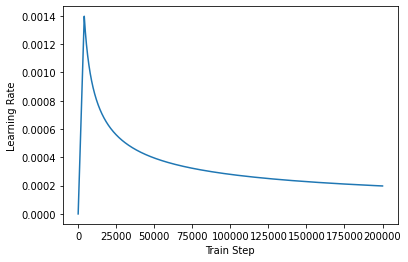

In [93]:
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

### 5.5 모델 컴파일

In [94]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
    return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

### 5.6 모델 훈련하기

In [95]:
EPOCHS = 100 # dropout 0.5 100epochs 동문서답
model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/100
93/93 [==============================] - 22s 160ms/step - loss: 2.0078 - accuracy: 0.0066
Epoch 2/100
93/93 [==============================] - 15s 160ms/step - loss: 1.8151 - accuracy: 0.0658
Epoch 3/100
93/93 [==============================] - 15s 160ms/step - loss: 1.6087 - accuracy: 0.0844
Epoch 4/100
93/93 [==============================] - 15s 160ms/step - loss: 1.4218 - accuracy: 0.0860
Epoch 5/100
93/93 [==============================] - 15s 160ms/step - loss: 1.2472 - accuracy: 0.0873
Epoch 6/100
93/93 [==============================] - 15s 160ms/step - loss: 1.1612 - accuracy: 0.0876
Epoch 7/100
93/93 [==============================] - 15s 160ms/step - loss: 1.1249 - accuracy: 0.0880
Epoch 8/100
93/93 [==============================] - 15s 160ms/step - loss: 1.0872 - accuracy: 0.0883
Epoch 9/100
93/93 [==============================] - 15s 161ms/step - loss: 1.0574 - accuracy: 0.0887
Epoch 10/100
93/93 [==============================] - 15s 161ms/step - loss: 1.030

## 6. 모델 평가하기

In [119]:
def decoder_inference(sentence, prob = False):
    sentence = encoder_preprocessing(sentence)
    # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
    # ex) Where have you been? → [[8331   86   30    5 1059    7 8332]]
    sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

    # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
    # 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장. ex) 8331
    output_sequence = tf.expand_dims(START_TOKEN, 0)

    # 디코더의 인퍼런스 단계
    for i in range(MAX_LENGTH):
        # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
        predictions = model(inputs=[sentence, output_sequence], training=False)
        
        # 다양한 답변을 출력하기 위해서 첫 단어는 확률적으로 선택
        if prob == True:
            predictions = (tf.exp(predictions[0,0]) / tf.math.reduce_sum(tf.exp(predictions[0,0]))).numpy()
            predicted_id = np.random.choice(range(VOCAB_SIZE), p = predictions, replace = False)
            predicted_id =  np.expand_dims(predicted_id, [0, 1]) 
            predicted_id = tf.cast(predicted_id, tf.int32)
        # 첫 단어 이후는 가장 점수가 높은 단어 선택
        else:
            predictions = model(inputs=[sentence, output_sequence], training=False)
            predictions = predictions[:, -1:, :]
            predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)
        # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
        if tf.equal(predicted_id, END_TOKEN[0]):
            break
        
        # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
        # 이 output_sequence는 다시 디코더의 입력이 됩니다.
        output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

    return tf.squeeze(output_sequence, axis=0)

In [120]:
def sentence_generation(sentence, prob):
    # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받습니다.
    prediction = decoder_inference(sentence, prob = prob)

    # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
    predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

    print('입력 : {}'.format(sentence))
    print('출력 : {}'.format(predicted_sentence))

    return predicted_sentence

In [130]:
input_sentence = '기분이 이상해'
result = sentence_generation(input_sentence, prob = False)

입력 : 기분이 이상해
출력 : 무슨 이유인지 생각해보세요.


In [132]:
input_sentence = '안녕'
print(encoder_preprocessing(input_sentence))
result = sentence_generation(input_sentence, prob = False)

안녕
입력 : 안녕
출력 : 안녕하세요.


In [137]:
input_sentence = '월요일이라 힘들어 위로 해줘'
print(encoder_preprocessing(input_sentence))
result = sentence_generation(input_sentence, prob = False)

월요일 라 힘들 어 위 로 해 줘
입력 : 월요일이라 힘들어 위로 해줘
출력 : �피드조심하세요.


## 7. Subwordencoding에서 Mecab을 사용한 벡터화

기존에는 subwordencoding 방법을 사용하여 단어를 벡터화 시켜주었습니다.  
지금부터는 기존에 형태소 분석기인 mecab을 사용하여 단어를 분리하고 분리된 단어들을 따로 인덱스를 부여하여 새로운 벡터화를 진행하겠습니다.

In [91]:
mecab_q_and_a = list(map(lambda x : mecab.morphs(x), q_and_a))
mecab_q_and_a[:5]

[['12', '시', '땡'],
 ['1', '지망', '학교', '떨어졌', '어'],
 ['3', '박', '4', '일', '놀', '러', '고', '싶', '다'],
 ['3', '박', '4', '일', '정도', '놀', '러', '고', '싶', '다'],
 ['심하', '네']]

mecab이 나눈 단위대로 단어 행렬을 만들어 줍니다.

In [92]:
word_dict = defaultdict()
for sentence in mecab_q_and_a:
    for word in sentence:
        if word in word_dict:
            word_dict[word] += 1
        else:
            word_dict[word] = 1
word_dict = dict(word_dict)
print(f"총 단어의 개수 : {len(word_dict)}")

총 단어의 개수 : 6797


새로 만들어진 단어의 개수는 총 6797개가 나왔습니다.  
해당 단어들을 기반으로 단어들을 빈도를 기반으로 정렬을 한 뒤, 인덱스를 부여하여 단어 벡터화를 진행하겠습니다.

In [93]:
sorted_word = sorted(word_dict.items(), key = lambda x: x[1], reverse = True)

word_index = dict()
for i in range(len(word_dict)):
    word_index[sorted_word[i][0]] = i + 3    
word_index["<start>"] = 0
word_index["<end>"] = 1
word_index["<pad>"] = 2


index_word = dict()
for i in range(len(word_dict)):
    index_word[i + 3] = sorted_word[i][0]
index_word[0] = "<start>"
index_word[1] = "<end>"
index_word[2] = "<pad>"

In [94]:
# 최대 문장에 들어가는 단어의 개수
MAX_LENGTH = 35

token_Q = list(map(lambda x: [0] + [word_index[i] for i in mecab.morphs(x)] + [1] ,Q))
token_Q = tf.keras.preprocessing.sequence.pad_sequences(token_Q,
                                                        maxlen=MAX_LENGTH, 
                                                        padding='post',
                                                        value = word_index["<pad>"]
                                                       )
token_A = list(map(lambda x: [0] + [word_index[i] for i in mecab.morphs(x)] + [1] ,A))
token_A = tf.keras.preprocessing.sequence.pad_sequences(token_A,
                                                        maxlen=MAX_LENGTH, 
                                                        padding='post',
                                                        value = word_index["<pad>"]
                                                       )

단어에서 인덱스로, 인덱스에서 단어로 가는 dictionary를 만든 뒤, 질문 데이터와 답변 데이터들의 단어들을 모두 벡터화 시키고 post padding을 적용시켜주겠습니다.

dictionary에는 start, end, padding 토큰을 추가해주겠습니다.

In [96]:
BATCH_SIZE = 128
BUFFER_SIZE = len(token_Q)

# 디코더는 이전의 target을 다음의 input으로 사용합니다.
# 이에 따라 outputs에서는 START_TOKEN을 제거하겠습니다.
mecab_dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': token_Q,
        'dec_inputs': token_A[:, :-1]
    },
    {
        'outputs': token_A[:, 1:]
    },
))

mecab_dataset = mecab_dataset.cache()
mecab_dataset = mecab_dataset.shuffle(BUFFER_SIZE)
mecab_dataset = mecab_dataset.batch(BATCH_SIZE)
mecab_dataset = mecab_dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [97]:
next(iter(mecab_dataset))[0]

{'inputs': <tf.Tensor: shape=(128, 35), dtype=int32, numpy=
 array([[   0,  502,   81, ...,    2,    2,    2],
        [   0,  207, 1408, ...,    2,    2,    2],
        [   0,   55,    4, ...,    2,    2,    2],
        ...,
        [   0, 1172,  377, ...,    2,    2,    2],
        [   0,  196,  279, ...,    2,    2,    2],
        [   0,  180,   97, ...,    2,    2,    2]], dtype=int32)>,
 'dec_inputs': <tf.Tensor: shape=(128, 34), dtype=int32, numpy=
 array([[   0,  385,  229, ...,    2,    2,    2],
        [   0,  207,   26, ...,    2,    2,    2],
        [   0,   85,   24, ...,    2,    2,    2],
        ...,
        [   0,  166,   15, ...,    2,    2,    2],
        [   0,  185,    4, ...,    2,    2,    2],
        [   0, 1033,  356, ...,    2,    2,    2]], dtype=int32)>}

전처리와 벡터화가 완료된 데이터셋을 텐서플로우 데이터셋으로 바꾸면서 모델의 입력과 출력으로 들어가는 구조를 설계합니다.

모델의 입력 변수는 input_encoder, input_decoder를 만들고 출력 변수는 output_decoder의 형태로 만들겠습니다.

In [98]:
word2vec_path = './ko.bin'
mecab_word2vec = gensim.models.Word2Vec.load(word2vec_path)
word_vector_dim = 200  # 워드 벡터의 차원수
vocab_size = len(word_dict) + 3
mecab_embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

tmp = 0
# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(vocab_size):
    if index_word[i] in mecab_word2vec:
        tmp += 1
        mecab_embedding_matrix[i] = mecab_word2vec[index_word[i]]
print(f"사전 학습된 임베딩 벡터를 사용할 수 있는 단어의 개수 : {tmp}")
mecab_embedding_matrix.shape

사전 학습된 임베딩 벡터를 사용할 수 있는 단어의 개수 : 3637


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':


(6800, 200)

사전에 학습되어진 임베딩 벡터를 불러와서 임베딩 층은 전이학습을 적용하겠습니다.

총 단어의 개수는 6800개이고 200 차원이며 사용 가능한 사전 학습 단어의 개수는 3637개입니다.

In [99]:
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")

    # 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # 임베딩 레이어
    embeddings = tf.keras.layers.Embedding(
        vocab_size, 
        d_model,
        embeddings_initializer=Constant(mecab_embedding_matrix),
        trainable=True
    )(inputs)
    #embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

    # 포지셔널 인코딩
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    # num_layers만큼 쌓아올린 인코더의 층.
    for i in range(num_layers):
        outputs = encoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name="encoder_layer_{}".format(i),
        )([outputs, padding_mask])

    return tf.keras.Model(
        inputs=[inputs, padding_mask], outputs=outputs, name=name)

def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
    inputs = tf.keras.Input(shape=(None,), name='inputs')
    enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
    look_ahead_mask = tf.keras.Input(
        shape=(1, None, None), name='look_ahead_mask')

    # 패딩 마스크
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
  
    # 임베딩 레이어
    embeddings = tf.keras.layers.Embedding(
        vocab_size, 
        d_model,
        embeddings_initializer=Constant(mecab_embedding_matrix),
        trainable=True
    )(inputs)
    #embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

    # 포지셔널 인코딩
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    # Dropout이라는 훈련을 돕는 테크닉을 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    for i in range(num_layers):
        outputs = decoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name='decoder_layer_{}'.format(i),
        )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

    return tf.keras.Model(
        inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
        outputs=outputs,
        name=name)

def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

    # 인코더에서 패딩을 위한 마스크
    enc_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None),
        name='enc_padding_mask')(inputs)

    # 디코더에서 미래의 토큰을 마스크 하기 위해서 사용합니다.
    # 내부적으로 패딩 마스크도 포함되어져 있습니다.
    look_ahead_mask = tf.keras.layers.Lambda(
        create_look_ahead_mask,
        output_shape=(1, None, None),
        name='look_ahead_mask')(dec_inputs)

    # 두 번째 어텐션 블록에서 인코더의 벡터들을 마스킹
    # 디코더에서 패딩을 위한 마스크
    dec_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None),
        name='dec_padding_mask')(inputs)

    # 인코더
    enc_outputs = encoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
    )(inputs=[inputs, enc_padding_mask])

    # 디코더
    dec_outputs = decoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
    )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

    # 완전연결층
    outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

    return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

기존에 사용하던 임베딩 벡터가 아닌 새로운 임베딩 벡터를 사용하기에 다시 함수를 호출하여 현재 사용하는 임베딩 벡터로 바꿔주어야 합니다.

In [109]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = word_vector_dim # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.7 # 드롭아웃의 비율

mecab_model = transformer(
    vocab_size=vocab_size,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

mecab_model.summary()

learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
    return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

mecab_model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 200)    2094224     inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

지금까지 설정한 모델의 구조를 compile 시켜줌으로써 새로운 모델을 만들 준비가 완료되었습니다.

In [110]:
def mecab_decoder_inference(sentence, prob = False):
    sentence = encoder_preprocessing(sentence)
    # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
    # ex) Where have you been? → [[8331   86   30    5 1059    7 8332]]
    sentence = tf.expand_dims([0] + [word_index[word] for word in mecab.morphs(sentence)] + [1], axis=0)
    # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
    # 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장. ex) 8331

    sentence = tf.keras.preprocessing.sequence.pad_sequences(sentence,
                                                            maxlen=MAX_LENGTH, 
                                                            padding='post',
                                                            value = word_index["<pad>"]
                                                           )
    
    output_sequence = tf.expand_dims([0], 0)

    # 디코더의 인퍼런스 단계
    for i in range(MAX_LENGTH):
        # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
        predictions = mecab_model(inputs=[sentence, output_sequence], training = False)
        
        # 다양한 답변을 출력하기 위해서 첫 단어는 확률적으로 선택
        if prob == True:
            predictions = (tf.exp(predictions[0,0]) / tf.math.reduce_sum(tf.exp(predictions[0,0]))).numpy()
            predicted_id = np.random.choice(range(vocab_size), p = predictions, replace = False)
            predicted_id =  np.expand_dims(predicted_id, [0, 1]) 
            predicted_id = tf.cast(predicted_id, tf.int32)
        # 첫 단어 이후는 가장 점수가 높은 단어 선택
        else:
            predictions = mecab_model(inputs=[sentence, output_sequence], training=False)
            predictions = predictions[:, -1:, :]
            predicted_id = tf.cast(tf.argmax(predictions, axis = -1), tf.int32)
        # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
        if tf.equal(predicted_id, [1]):
            break
        
        # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
        # 이 output_sequence는 다시 디코더의 입력이 됩니다.
        output_sequence = tf.concat([output_sequence, predicted_id], axis = -1)

    return tf.squeeze(output_sequence, axis=0)

def mecab_sentence_generation(sentence, prob):
    # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받습니다.
    prediction = mecab_decoder_inference(sentence, prob = prob)

    # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
    predicted_sentence = [index_word[i] for i in prediction.numpy()]
    predicted_sentence = " ".join(predicted_sentence[1:])
    print('입력 : {}'.format(sentence))
    print('출력 : {}'.format(predicted_sentence))

    return predicted_sentence

모델이 학습을 하는 동안 예제의 결과가 어떻게 나오는지 중간중간 확인하기 위해서 모델의 테스트 함수를 미리 호출시켜놓습니다.

In [111]:
EPOCHS = 100

for i in range(EPOCHS + 1):
    mecab_model.fit(mecab_dataset, epochs=1, verbose=1)
    if i % 3 == 0:
        input_sentence = '안녕하세요'
        result = mecab_sentence_generation(input_sentence, prob = False)
        print("\n")

93/93 [==============================] - 21s 152ms/step - loss: 8.7631 - accuracy: 0.0495
입력 : 안녕하세요
출력 : <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


93/93 [==============================] - 14s 153ms/step - loss: 2.6080 - accuracy: 0.7242
입력 : 안녕하세요
출력 : <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


93/93 [==============================] - 14s 153ms/step - loss: 1.4987 - accuracy: 0.7616
입력 : 안녕하세요
출력 : .


93/93 [==============================] - 14s 153ms/step - loss: 1.2620 - accuracy: 0.7929
입력 : 안녕하세요
출력 : 하 는 이 는 이 하 세요 .


93/93 [==============================] - 14s 154ms/step - loss: 1.1360 - accuracy: 0.8097
입력 : 안녕하세요
출력 : 하 는 사람 이 에요 .


93/93 [

In [112]:
input_sentence = '밥먹자'
result = mecab_sentence_generation(input_sentence, prob = False)

입력 : 밥먹자
출력 : 드세요 .


말이 많이 짧지만 그래도 생각보다 정상적인 반응을 하는 챗봇 모델을 완성할 수 있었습니다.